# Accent Classification - Extract `logspec200` Features from Audio Files

In [1]:
import pandas as pd
import numpy as np
import librosa
import pickle, gzip
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from collections import defaultdict
import gc

## Files Organization

The files are organized into these folders:


|Folder|Content|
|:---|:---|
|__./audio__|train and dev sets .wav files (see below for folder structure)|
|__./testaudio__|test set .wav files|
|__./metadata__|various metadata: `utt`, `label`, `sex`, `age`, utt to file paths for test set|
|__./features__| the extracted features (\*.pkl.gz)|

#### train and dev set .wav folder structure

```
audio/  
   +---CHN/
   |     +----G0021/
   |             |------G00021S1053.wav
   |             |------   .
   |             |------   .
   +---IND
   +--- .
   +--- .
   +---US
```   

If the database is located in harddisk, create a symbolic link to this notebook's working directory. 

In [3]:
if True:
    #create symbolic link as database is located in harddisk
    !ln -s /Volumes/AIWorks/accented_ASR/audio/ ~/MSAI/Accent/AccentRecognition/audio
    !ln -s /Volumes/AIWorks/accented_ASR/features/ ~/MSAI/Accent/AccentRecognition/features
    !ln -s /Volumes/AIWorks/accented_ASR/kaldi_formatted_data/ ~/MSAI/Accent/AccentRecognition/metadata
    !ln -s /Volumes/AIWorks/accented_ASR/TESTSET/wav/ ~/MSAI/Accent/AccentRecognition/testaudio

ln: /Users/samsudinng/MSAI/Accent/AccentRecognition/audio/audio: File exists
ln: /Users/samsudinng/MSAI/Accent/AccentRecognition/features/features: File exists
ln: /Users/samsudinng/MSAI/Accent/AccentRecognition/metadata/kaldi_formatted_data: File exists
ln: /Users/samsudinng/MSAI/Accent/AccentRecognition/testaudio/wav: File exists


In [4]:
#############################
# CONSTANTS AND LOOKUP TABLES 
#############################

#to map accent from Kaldi utt2accent to the corresponding accent folder
accent_dir = {
    'BRITISH'   : 'UK',       
    'AMERICAN'  : 'US',
    'PORTUGUESE': 'PT',  
    'KOREAN'    : 'KR',
    'JAPANESE'  : 'JPN',
    'RUSSIAN'   : 'RU',
    'CHINESE'   : 'CHN',
    'INDIAN'    : 'IND'   
}

#various spectrogram parameters
spectrogram_params = {
    'logspec200': {    # this is the same setting as SER features
        'window'        : 'hamming',
        'sampling_freq' : 16000,
        'win_len'       : 40, #msec
        'hop_len'       : 10, #msec
        'ndft'          : 800,
        'nfreq'         : 200,
        'segment_size'  : 300,
        'output_folder' : 'logspec200'
    }
}

## 0. Set the parameter here (file paths, spectrogram parameters)

In [5]:
############################
# FILE RELATED 
############################

# use same split as Kaldi features
train_label_file ='./metadata/train_utt2accent'
dev_label_file ='./metadata/dev_utt2accent'
train_gender_label_file ='./metadata/train_utt2sex'
dev_gender_label_file ='./metadata/dev_utt2sex'
train_age_label_file ='./metadata/train_utt2age'
dev_age_label_file ='./metadata/dev_utt2age'
test_label_file ='./metadata/test_utt2accent'
test_wav_scp='./metadata/test_wav.scp'
train_on_subset = {'activate': False, 'size':0.3}
calculate_zscore = False
feature_setting = 'logspec200'


############################
# SPECTROGRAM PARAMETERS
############################
spec_params = spectrogram_params[feature_setting]

#path to the audio
wavdir = 'audio/'
testwavdir= 'testaudio/'
outdir = f"features/{spec_params['output_folder']}/"


## 1. Get the wav file paths for each utterance in train, dev and test set

The paths and metadata is contained in dataframes `train_df`, `dev_df` and `test_df`. Each dataframe contain the following columns:

1. `utt`    : the utterance label
2. `label`  : the accent label (int, {0 .. 7})
3. `gender` : the gender label (int, {0 .. 1})
4. `age`    : the age (int)
5. `wavfile`: full path to the utterance's .wav file


|    |utt	                                        |label|gender    |age    |wavfile|
|:---|:---|:---|:---|:---|:---|
|0	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1001	|0	  |1	     |21	 |audio/US/G00473/G00473S1001.wav|
|1	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1002	|0	  |1	     |21	 |audio/US/G00473/G00473S1002.wav|
|2	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1003	|0	  |1	     |21	 |audio/US/G00473/G00473S1003.wav|
|3	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1004	|0	  |1	     |21	 |audio/US/G00473/G00473S1004.wav|
|4	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1006	|0	  |1	     |21	 |audio/US/G00473/G00473S1006.wav|


In [6]:
# Train labels
train_labels = pd.read_csv(train_label_file, names = ['utt','label'], header=None, 
                           delim_whitespace=True,index_col='utt')
gender = pd.read_csv(train_gender_label_file, names = ['utt','gender'],header=None, 
                     delim_whitespace=True,index_col='utt')
age = pd.read_csv(train_age_label_file, names = ['utt','age'], header=None, 
                  delim_whitespace=True,index_col='utt')
train_labels['gender'] = gender
train_labels['age'] = age
train_labels.reset_index(inplace=True)


# Dev labels
dev_labels = pd.read_csv(dev_label_file, names = ['utt','label'], header=None, 
                           delim_whitespace=True,index_col='utt')
gender = pd.read_csv(dev_gender_label_file, names = ['utt','gender'],header=None, 
                     delim_whitespace=True,index_col='utt')
age = pd.read_csv(dev_age_label_file, names = ['utt','age'], header=None, 
                  delim_whitespace=True,index_col='utt')
dev_labels['gender'] = gender
dev_labels['age'] = age
dev_labels.reset_index(inplace=True)



# Test labels
test_labels = pd.read_csv(test_label_file, names=['utt','label'], header=None, 
                          delim_whitespace=True,index_col='utt') 



"""
Train Set
"""
#extract the file path from `utt`
accent = train_labels.utt.str.split(pat='-',expand=True).iloc[:,1].map(accent_dir).tolist()
speaker = train_labels.utt.str.split(pat='-',expand=True).iloc[:,3].tolist()
utt  = train_labels.utt.str.split(pat='-',expand=True).iloc[:,4].tolist()
wavfile = list(zip(accent,speaker,utt))
train_labels['wavfile'] = [wavdir+'/'.join(s)+'.wav' for s in wavfile]

train_df = train_labels
print(f'TRAIN set:\n# utterances: {train_labels.shape[0]}\n{train_labels.head()}\n')

"""
Dev Set
"""
#extract the file path from `utt`
accent = dev_labels.utt.str.split(pat='-',expand=True).iloc[:,1].map(accent_dir).tolist()
speaker = dev_labels.utt.str.split(pat='-',expand=True).iloc[:,3].tolist()
utt  = dev_labels.utt.str.split(pat='-',expand=True).iloc[:,4].tolist()
wavfile = list(zip(accent,speaker,utt))
dev_labels['wavfile'] = [wavdir+'/'.join(s)+'.wav' for s in wavfile]

dev_df = dev_labels
print(f'DEV set:\n# utterances: {dev_labels.shape[0]}\n{dev_labels.head()}')


"""
Test Set
"""
#get the file path from wav.scp
with open(test_wav_scp) as ff:
    Lines = ff.readlines()
    n_lines = len(Lines)

utt,wavfile = zip(*[ln.rstrip().split('  ') for ln in Lines])
wavfile = [testwavdir+f.split('/')[-1] for f in wavfile]

testwav = pd.DataFrame(zip(utt,wavfile),columns=['utt','wavfile']).set_index('utt')
test_labels['wavfile'] = testwav
test_labels.reset_index(inplace=True)


test_df = test_labels
print(f'TEST set:\n# utterances: {test_labels.shape[0]}\n{test_labels.head()}')

TRAIN set:
# utterances: 124541
                                            utt  label  gender  age  \
0  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1001      0       1   21   
1  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1002      0       1   21   
2  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1003      0       1   21   
3  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1004      0       1   21   
4  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1006      0       1   21   

                           wavfile  
0  audio/US/G00473/G00473S1001.wav  
1  audio/US/G00473/G00473S1002.wav  
2  audio/US/G00473/G00473S1003.wav  
3  audio/US/G00473/G00473S1004.wav  
4  audio/US/G00473/G00473S1006.wav  

DEV set:
# utterances: 11988
                                            utt  label  gender  age  \
0  AESRC2020-AMERICAN-ACCENT-G00007-G00007S1001      0       0   20   
1  AESRC2020-AMERICAN-ACCENT-G00007-G00007S1002      0       0   20   
2  AESRC2020-AMERICAN-ACCENT-G00007-G00007S1004      0       0   20   
3  AE

### 1.1 Label Distribution

Text(0.5, 1.0, 'test dataset (14493 utt)')

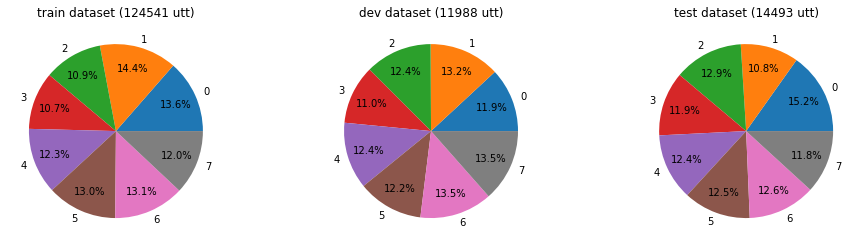

In [8]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
train_labels['label'].value_counts().sort_index().plot.pie(autopct='%1.1f%%', label='',pctdistance=0.75)
plt.title(f'train dataset ({len(train_df)} utt)')
plt.subplot(1,3,2)
dev_labels['label'].value_counts().sort_index().plot.pie(autopct='%1.1f%%',label='',pctdistance=0.75)
plt.title(f'dev dataset ({len(dev_df)} utt)')
plt.subplot(1,3,3)
test_labels['label'].value_counts().sort_index().plot.pie(autopct='%1.1f%%',label='',pctdistance=0.75)
plt.title(f'test dataset ({len(test_df)} utt)')

### 1.2  Activate this to train on smaller subset of the dataset

The subset is splitted into `train_on_subset['n_split']` with StratifiedShuffleSplit to maintain the proportion of the labels. One of the split is taken as training set.

In [9]:
if train_on_subset['activate'] == True:
    #partial training set, smaller size
    from sklearn.model_selection import StratifiedShuffleSplit

    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_on_subset['size'], random_state=100)
    
    #subset on training data
    trlabels = train_labels.label.tolist()
    trutt    = train_labels.wavfile.tolist()
    
    for tr, tst in sss.split(trutt, trlabels):
        print(len(tr))
        train_subset_idx = tr

    train_subset = [trlabels[idx] for idx in train_subset_idx]
    train_subset = pd.Series(train_subset)
    print(f'Train Subset label distribution:\n{train_subset.value_counts().sort_index()}')
    
    #subset on dev data
    devlabels = dev_labels.label.tolist()
    devutt    = dev_labels.wavfile.tolist()
    
    for tr, tst in sss.split(devutt, devlabels):
        print(len(tr))
        dev_subset_idx = tr

    dev_subset = [devlabels[idx] for idx in dev_subset_idx]
    dev_subset = pd.Series(dev_subset)
    print(f'Dev Subset label distribution:\n{dev_subset.value_counts().sort_index()}')
    
    #get subset dataframe
    train_subset_labels = train_labels[train_labels.index.isin(list(train_subset_idx))].copy()
    train_df = train_subset_labels.reset_index(drop=True)
    print(train_df.head())
    
    dev_subset_labels = dev_labels[dev_labels.index.isin(list(dev_subset_idx))].copy()
    dev_df = dev_subset_labels.reset_index(drop=True)
    print(dev_df.head())
    
    feature_setting += '_partial'

## 2. Generate Spectrogram Features


#### 2.1 Calculate zscore scaler 

- calculate and save StandardScaler based on the whole training set to perform spectrogram standardization to zero mean and unit standar deviation
- can also be loaded from .pkl file if pre-computed

#### 2.2 Audio to Spectrogram Image

   - pre-emphasis filtering
   - convert to spectrogram
   - zscore standardization
   - Each spectrogram is normalizated to [0.0, 1.0] range based on its corresponding max value
   - quantize to uint8 ([0, 255])
   - save all quantized features as dictionary (```all_spec```)
      - key  : utterance name (eg. ```AESRC2020-AMERICAN-ACCENT-G00473-G00473S1028```)
      - value: numpy array (uint8), shape = (F, T)
   - write to .pkl.gz
    


In [10]:
def calculate_log_spectrogram(x, sr, params):
    
    #convert msec to samples
    win_len = int(params['win_len'] * sr / 1000)
    hop_len = int(params['hop_len'] * sr / 1000)
    
    # Apply pre-emphasis filter
    x = librosa.effects.preemphasis(x, zi = [0.0])

    #calculate log-spectrogram
    spec = np.abs(librosa.stft(x, n_fft=params['ndft'],hop_length=hop_len,
                                        win_length=win_len,
                                        window=params['window']))
    
    spec =  librosa.amplitude_to_db(spec, ref=np.max)
    
    #extract the required frequency bins
    spec = spec[:params['nfreq']]
    
    
    return spec #(F, T)


def get_data_range(x):
    
    max_val = np.max(x.flatten())
    min_val = np.min(x.flatten())
    
    return max_val, min_val

    
def calculate_zscore_scaler(train_labels):
    
    zscore_scaler = StandardScaler() #z-score standardize the spectrogram
    calculate_every = 200
    
    all_spec=[]
    for row, col in tqdm(train_labels.iterrows()):
        wavfilename = col['wavfile']
    
        #Read utterance wav file
        x, sr = librosa.load(wavfilename, sr=None)
        assert sr == spec_params['sampling_freq']
    
        #Calculate log spectrogram
        log_spec = calculate_log_spectrogram(x, sr, spec_params)
        all_spec.append(log_spec.T)
    
        #Calculate (partial) scaling factors based on overall training set
        if row > 0 and row % (calculate_every-1) == 0:
            zscore_scaler.partial_fit(np.vstack(all_spec))   
            all_spec[:] = []
    
    #last block
    zscore_scaler.partial_fit(np.vstack(all_spec))
    
    return zscore_scaler


def extract_feature_image(df, spec_params, zscore_scaler, data_range):
    
    all_spec={}
    minmax_scaler = MinMaxScaler(feature_range=(0,1))
    
    for row, col in tqdm(df.iterrows()):
        utt = col['utt']
        label = col['label']
        wavfilename = col['wavfile']
    
        #Read utterance wav file
        x, sr = librosa.load(wavfilename, sr=None)
        assert sr == spec_params['sampling_freq']
    
        #Calculate log spectrogram
        log_spec = calculate_log_spectrogram(x, sr, spec_params)
    
        #Standardization
        vmax,vmin = get_data_range(log_spec)
        data_range['max_ori'].append(vmax)
        data_range['min_ori'].append(vmin)
        log_spec = zscore_scaler.transform(log_spec.T)
        vmax,vmin = get_data_range(log_spec)
        data_range['max_std'].append(vmax)
        data_range['min_std'].append(vmin)
    
        #Convert range to [0, 1] and quantize to uint8
        minmax_scaler.fit(log_spec)
        log_spec = minmax_scaler.transform(log_spec)
        log_spec = (log_spec*255).astype(np.uint8)
    
        all_spec[utt] = np.flipud(log_spec.T)
         
    return all_spec, data_range
    
    

### 2.1 Calculate zscore scaler

In [72]:
if calculate_zscore == True:
    all_log_spec = {}

    zscore_scaler = calculate_zscore_scaler(train_df)

    with open(f'{outdir}zscore_scaler_{feature_setting}.pkl','wb') as fi:
        pickle.dump(zscore_scaler, fi)
else:
    with open(f'{outdir}zscore_scaler_{feature_setting}.pkl','rb') as fi:
        zscore_scaler = pickle.load(fi)
    

### 2.2.1 Training data

In [19]:
data_range = defaultdict(list)

#split features into chunks
nsplit = 8
split_size = int(np.floor(len(train_df)/nsplit))
split_start = [split_size*idx for idx in list(range(0,nsplit,1))]
split_end = [split_size*idx for idx in list(range(1,nsplit,1))]
split_end.append(len(train_df))
split_idx = zip(split_start, split_end)


for chunk, idx in enumerate(split_idx):
    start,end = idx
    
    print(f'Chunk {chunk}/{nsplit}\n')
    all_spec, data_range = extract_feature_image(train_df.iloc[start:end,:], spec_params, zscore_scaler, data_range)

    pickle.dump( all_spec, gzip.open( f'{outdir}train_{feature_setting}_{chunk}.pkl.gz',   'wb' ) )
    
    del all_spec
    gc.collect()

gmin = min(data_range['min_ori'])
gmax = max(data_range['max_ori'])
print(f'Data range original    : min: {gmin} - max: {gmax}')

gmin = min(data_range['min_std'])
gmax = max(data_range['max_std'])
print(f'Data range standardized: min: {gmin} - max: {gmax}')

del data_range
gc.collect()

10it [00:00, 92.57it/s]

Chunk 0/8



4670it [00:41, 112.05it/s]
11it [00:00, 102.30it/s]

Chunk 1/8



4670it [00:42, 110.87it/s]
10it [00:00, 90.66it/s]

Chunk 2/8



4670it [00:48, 96.29it/s] 
6it [00:00, 55.23it/s]

Chunk 3/8



4670it [00:57, 81.40it/s] 
9it [00:00, 86.53it/s]

Chunk 4/8



4670it [00:43, 107.24it/s]
9it [00:00, 87.25it/s]

Chunk 5/8



4670it [00:46, 100.98it/s]
9it [00:00, 84.92it/s]

Chunk 6/8



4670it [00:45, 102.27it/s]
8it [00:00, 79.54it/s]

Chunk 7/8



4672it [00:49, 95.11it/s] 


Data range original    : min: -80.0 - max: 3.814697265625e-06
Data range standardized: min: -1.6011382341384888 - max: 7.5863189697265625


0

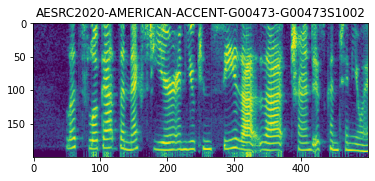

2624

In [21]:
with gzip.open(f'{outdir}train_{feature_setting}_0.pkl.gz', 'rb') as f:
    allspec = pickle.load(f)

utt = list(allspec.keys())[0]
img = allspec[utt]

plt.figure()
plt.imshow(img[:,:500])
plt.title(utt)
plt.show()

del allspec
gc.collect()

### 2.2.2 Dev data

In [23]:
all_spec={}
minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_range = defaultdict(list)

all_spec, data_range = extract_feature_image(dev_df, spec_params, zscore_scaler, data_range)


gmin = min(data_range['min_ori'])
gmax = max(data_range['max_ori'])
print(f'Data range original    : min: {gmin} - max: {gmax}')

gmin = min(data_range['min_std'])
gmax = max(data_range['max_std'])
print(f'Data range standardized: min: {gmin} - max: {gmax}')
pickle.dump( all_spec, gzip.open( f'{outdir}dev_{feature_setting}_0.pkl.gz',   'wb' ) )

3596it [00:49, 72.36it/s] 


Data range original    : min: -80.0 - max: 1.9073486328125e-06
Data range standardized: min: -1.6011382341384888 - max: 7.598281383514404


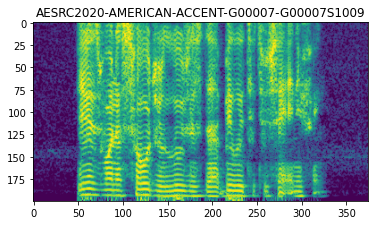

In [24]:
with gzip.open(f'{outdir}dev_{feature_setting}_0.pkl.gz', 'rb') as f:
    allspec = pickle.load(f)

utt = list(allspec.keys())[0]
img = allspec[utt]

plt.figure()
plt.imshow(img[:,:500])
plt.title(utt)
plt.show()

### 2.2.3 Test data (in-progress)

In [73]:
all_spec={}
minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_range = defaultdict(list)

all_spec, data_range = extract_feature_image(test_df, spec_params, zscore_scaler, data_range)


gmin = min(data_range['min_ori'])
gmax = max(data_range['max_ori'])
print(f'Data range original    : min: {gmin} - max: {gmax}')

gmin = min(data_range['min_std'])
gmax = max(data_range['max_std'])
print(f'Data range standardized: min: {gmin} - max: {gmax}')
pickle.dump( all_spec, gzip.open( f'{outdir}test_{feature_setting}_0.pkl.gz',   'wb' ) )

14493it [02:30, 96.14it/s] 


Data range original    : min: -80.0 - max: 3.814697265625e-06
Data range standardized: min: -1.6000478267669678 - max: 7.652339458465576


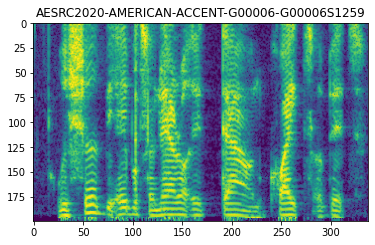

In [6]:
with gzip.open(f'{outdir}test_{feature_setting}_0.pkl.gz', 'rb') as f:
    allspec = pickle.load(f)

utt = list(allspec.keys())[0]
img = allspec[utt]

plt.figure()
plt.imshow(img[:,:500])
plt.title(utt)
plt.show()